# Import Packages

In [3]:
# Importing necessary libraries
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm.auto import tqdm

# Set the random seed for reproducibility
seed = 20230808
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set the device to GPU if available, otherwise use CPU
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Perform garbage collection and empty the GPU cache in PyTorch
gc.collect()
torch.cuda.empty_cache()


# Model

In [4]:
class NN(nn.Module):
    """
    A simple neural network class.

    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of hidden units in each hidden layer.
        output_size (int): The number of output features.
        depth (int): The number of hidden layers.
        ac (torch.nn.Module): The activation function to use for each hidden layer.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        ac=torch.nn.Tanh,
    ):
        super(NN, self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', ac()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, ac()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_size).
        """
        return self.layers(x)


# Training Loop

A one-dimensional wave equation is chosen for our experiments, which, in mathematical form, is defined as follows:

$$ u_{tt} - u_{xx} = 0$$

for this wave equation, its initial conditions and the homogeneous Dirichlet boundary conditions are given, as follows:

$$ u(0, x) = \frac{1}{2} \sin (\pi x)$$
$$ u_t(0, x) = \pi \sin (3 \pi x)$$
$$ u(t, 0) =  u(t, 1) = 0 $$

In [19]:
def init_weights(layer):
    """
    Initializes the weights of a layer with Xavier normal initialization.
    Args:
        layer (torch.nn.Module): The layer to initialize.
    """
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)


class Net:
    def __init__(self):
        # deep neural networks
        self.iter = 0
        self.model = NN(
            input_size=2,
            hidden_size=100,
            output_size=1,
            depth=6,
            ac=torch.nn.Tanh
        ).to(device)

        # use the Glorot normal initializer for initialization
        self.model.apply(init_weights)

        # The initial conditions, boundary conditions
        # with Nu approximating 300
        self.h = 0.01
        self.k = 0.01
        x_u = torch.arange(0, 1 + self.h, self.h)
        t_u = torch.arange(0, 1 + self.k, self.k)
        c0 = torch.stack(torch.meshgrid(x_u[0], t_u)).reshape(2, -1).T
        c1 = torch.stack(torch.meshgrid(x_u[-1], t_u)).reshape(2, -1).T
        c2 = torch.stack(torch.meshgrid(x_u, t_u[0])).reshape(2, -1).T
        y_c0 = torch.zeros(len(c0))
        y_c1 = torch.zeros(len(c1))
        y_c2 = 1/2*torch.sin(math.pi * c2[:, 0])
        self.X_u = torch.cat([c0, c1, c2]).to(device)
        self.y_u = torch.cat([y_c0, y_c1, y_c2]).unsqueeze(1).to(device)
        print(f'N_u is {self.X_u.shape[0]}')

        # Data in the space-time domain
        # with Nf approximating 40000
        self.h = 0.005
        self.k = 0.005
        x_f = torch.arange(0, 1 + self.h, self.h)
        t_f = torch.arange(0, 1 + self.k, self.k)
        self.X_f = torch.stack(torch.meshgrid(
            x_f, t_f)).reshape(2, -1).T.to(device)
        self.X_f.requires_grad = True
        print(f'N_f is {self.X_f.shape[0]}')

        # General Loss Function
        self.criterion = torch.nn.MSELoss(reduction='mean')

        # Two Optimizer
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=0.001,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe")

        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # loss using observations of initial and boundary conditions
        loss_u = self.criterion(self.model(self.X_u), self.y_u)

        # loss based on partial differential equations
        u = self.model(self.X_f)
        u_X = torch.autograd.grad(
            u, self.X_f
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x, u_t = du_dX[:, 0], du_dX[:, 1]

        u_xx = torch.autograd.grad(
            u_x, self.X_f,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        u_tt = torch.autograd.grad(
            u_t, self.X_f
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0][:, 1]

        loss_f = self.criterion(u_tt - u_xx, u_xx*0)
        loss = loss_u + loss_f
        loss.backward()
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (
                    self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()

        for _ in tqdm(range(20)):
            # L-BFGS 30,000 epochs
            self.optimizer.step(self.loss_func)
            # continued the optimization using Adam
            for _ in range(1500):
                self.adam.step(self.loss_func)


# Training

In [20]:
% % time

net = Net()
net.train()


N_u is 303
N_f is 40401


AttributeError: 'Net' object has no attribute 'X'

In [17]:
torch.save(net.model.state_dict(), 'model.ckpt')


# Evaluation

In [37]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plt.style.use(['ipynb', 'use_mathtext', 'colors5-light', 'science'])
# sns.set_style('whitegrid')
# sns.set_palette('RdBu')
# sns.set(
#     rc={'text.usetex': True},
#     font='serif',
#     font_scale=1.2
# )

# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['font.serif'] = ['SimHei']
# sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})


In [38]:
h = 0.01
k = 0.01
x = torch.arange(0, 1, h)
t = torch.arange(0, 1, k)
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)


In [39]:
def ground_truth(X):
    x = X[:, 0]
    t = X[:, 1]
    y = 1/2*torch.sin(torch.pi*x)*torch.cos(torch.pi*t)+1 / \
        3*torch.sin(3*torch.pi*x)*torch.sin(3*torch.pi*t)
    return y


In [40]:
model = NN(input_size=2,
           hidden_size=100,
           output_size=1,
           depth=6,
           ac=torch.nn.Tanh).to(device)
model.load_state_dict(torch.load('model.ckpt'))
model.eval()
with torch.no_grad():
    # y_pred = ground_truth(X).reshape(len(x), len(t)).detach().cpu()
    y_pred = model(X).reshape(len(x), len(t)).detach().cpu().numpy()


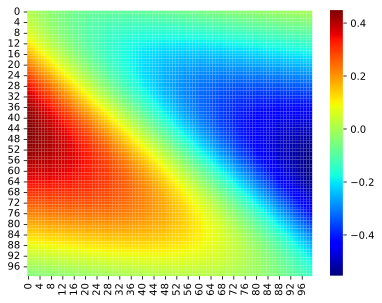

In [41]:
sns.heatmap(y_pred, cmap='jet')
plt.show()


In [42]:
y_pred.shape


(100, 100)

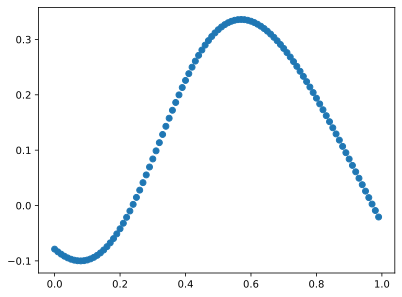

In [43]:
x = torch.arange(0, 1, h).unsqueeze(dim=1).to(device)
t = (torch.ones(x.shape)*0.2).to(device)

plt.scatter(x.detach().cpu(), model(torch.cat([x, t], dim=1)).detach().cpu())
